# Mimi-Project: Monet-Style Image Generation using CycleGAN

## Introduction

Art has always been defined by its unique creators, with iconic styles that transcend time and culture. The delicate brush strokes and vibrant color schemes of Claude Monet’s Impressionist paintings are instantly recognizable. Thanks to advancements in deep learning, we now have the ability to replicate such distinct styles through the use of CycleGAN, a type of Generative Adversarial Network (GAN) that can translate one image style into another without requiring paired training data. In this project, we will use CycleGAN to generate Monet-style images from photographs. Unlike traditional GANs, which learn to generate images from scratch, CycleGAN excels at style transfer, converting images from one domain (real-world photos) into another (Monet-style artwork). This framework is ideal for our task, as it allows us to train a model to recreate Monet’s signature style in any given image, capturing the ethereal quality of light and color that defines his work.

## Data Preparation and Simple EDA

To begin our image translation task using CycleGAN, we'll first establish the TPU environment. This involves configuring TensorFlow to utilize the TPU hardware for accelerated training. Once the TPU is set up, we'll load the Monet and photo datasets, which contain pairs of images that we aim to translate between. Finally, we'll conduct some simple exploratory data analysis (EDA) to gain insights into the characteristics of the data, such as image size, visualization of images. This initial exploration will help us make informed decisions about data preprocessing and model architecture.

In [22]:
# import libraries

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, Input, Add
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds
from tensorflow.keras.layers import LeakyReLU

import random
from random import randint
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import GroupNormalization



In [4]:
# set up tpu environment

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE


num_replicas = strategy.num_replicas_in_sync
print(num_replicas)

Number of replicas: 1
1


In [5]:
# helper function to load data

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
# load the dataset

monet_files = tf.io.gfile.glob("/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec")
print('Monet TFRecord Files:', len(monet_files))
photo_files = tf.io.gfile.glob("/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec")
print('Photo TFRecord Files:', len(photo_files))


monet_dataset = load_dataset(monet_files, labeled=True).batch(1)
photo_dataset = load_dataset(photo_files, labeled=True).batch(1)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [8]:
# The size of one image

def show_image_size(dataset):
    for image in dataset.take(1):
        image_shape = tf.shape(image)
        print(f"Image size: {image_shape.numpy()}") 

show_image_size(monet_dataset)
show_image_size(photo_dataset)

Image size: [  1 256 256   3]
Image size: [  1 256 256   3]


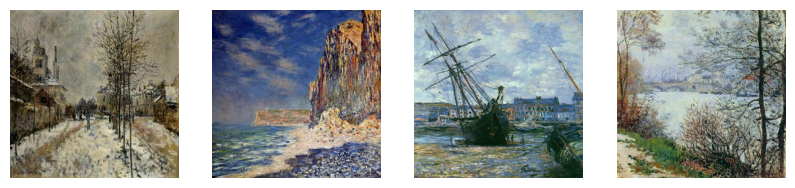

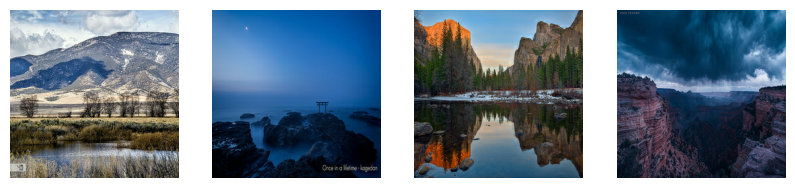

In [9]:
# Plotting the first 4 images from each dataset
def plot_images(dataset, num_images=4):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((image[0] + 1) / 2)  # Rescale to [0, 1]
        plt.axis('off')
    plt.show()

# Plot images from the monet dataset
plot_images(monet_dataset, num_images=4)

# Plot images from the photo dataset
plot_images(photo_dataset, num_images=4)

## Build the CycleGAN Model

CycleGAN is a generative adversarial network (GAN) architecture designed for image-to-image translation tasks, particularly when paired training data is not available. Unlike traditional GANs that require paired images, CycleGAN learns to map images from one domain to another by enforcing a cycle consistency constraint. This means that if you translate an image from domain A to domain B and then back to domain A, you should ideally get the original image.

Key components of CycleGAN:

- Two generators: One generator maps images from domain A to domain B, and the other maps images from domain B to domain A.
- Two discriminators: One discriminator evaluates the quality of images generated from domain A, and the other evaluates the quality of images generated from domain B.

In [11]:
# define the discriminator

def build_discriminator(img_shape):
    # initialization
    init = RandomNormal(stddev=0.02, seed=42)
    
    # Input layer
    input_img = layers.Input(shape=img_shape)
    
    # Downsampling
    x = Conv2D(64, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(x)
    x = GroupNormalization(groups=-1, axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(x)
    x = GroupNormalization(groups=-1, axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(x)
    x = GroupNormalization(groups=-1, axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, (4, 4), padding="same", kernel_initializer=init)(x)
    x = GroupNormalization(groups=-1, axis=-1)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Output layer
    output = Conv2D(1, (4, 4), padding="same", kernel_initializer=init)(x)

    # Build and compile the discriminator model
    discriminator = Model(inputs=input_img, outputs=output)
    discriminator.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

    return discriminator


In [12]:
# Define the Resnet block

def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02,seed=42)
    
    resnet_input = Input(shape=input_layer.shape[1:])
    
    x = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer=init)(resnet_input)
    x = GroupNormalization(groups=-1, axis=-1)(x)
    x = Activation("relu")(x)
    
    x = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer=init)(x)
    x = GroupNormalization(groups=-1, axis=-1)(x)

    resnet_output = Add()([x, resnet_input])
    
    return Model(inputs=resnet_input, outputs=resnet_output)


In [13]:
# Define the generator

def build_generator(img_shape, n_resnet=9):
    init = RandomNormal(stddev=0.02,seed=42)

    g = Sequential()

    g.add(Conv2D(64, (7, 7), padding="same", kernel_initializer=init, input_shape=img_shape))
    g.add(GroupNormalization(groups=-1, axis=-1))
    g.add(Activation("relu"))

    g.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init))
    g.add(GroupNormalization(groups=-1, axis=-1))
    g.add(Activation("relu"))

    g.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init))
    g.add(GroupNormalization(groups=-1, axis=-1))
    g.add(Activation("relu"))

    # Add resnet blocks
    for _ in range(n_resnet):
        g.add(resnet_block(256, g.layers[-1].output))

    g.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    g.add(GroupNormalization(groups=-1, axis=-1))
    g.add(Activation('relu'))

    g.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init))
    g.add(GroupNormalization(groups=-1, axis=-1))
    g.add(Activation('relu'))

    g.add(Conv2D(3, (7, 7), padding='same', kernel_initializer=init))
    g.add(GroupNormalization(groups=-1, axis=-1))
    g.add(Activation('tanh'))

    return g


In [14]:
# define the composite model

def composite_model(g_model_1, d_model, g_model_2, img_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # discriminator
    input_gen = Input(shape=img_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    
    # identity
    input_id = Input(shape=img_shape)
    output_id = g_model_1(input_id)
    
    # forward cycle
    output_f = g_model_2(gen1_out)
    
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    # compile model
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5))
    
    return model

In [16]:
# helper function to generate real and fake example



@tf.autograph.experimental.do_not_convert
def generate_real(dataset, n, patch_shape):
    num_elements = sum(1 for _ in dataset)
    if num_elements < n:
        n = num_elements
    indices = np.random.choice(num_elements, n, replace=False)
    subset_dataset = dataset.take(n)
    selected_examples = subset_dataset.enumerate().filter(lambda i, data: tf.math.reduce_any(tf.equal(i, indices))).map(lambda i, data: data)
    X = tf.squeeze(list(selected_examples), axis = 1)
    y = tf.ones((n, patch_shape, patch_shape, 1))
    return X, y

def generate_fake(generator, dataset, patch_shape):
    X = generator.predict(dataset)
    y = tf.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [17]:
# Define the image pool

from numpy import asarray

def update_image_pool(pool, images, max_size=50):
    select = list()
    for item in images:
        if len(pool) < max_size:
            pool.append(item)
            select.append(item)
        elif np.random.random() < 0.5:
            select.append(item)
        else:
            i = 0
            while(True):
                i = randint(0, len(pool))
                if i < len(pool):
                    break
            select.append(pool[i])
            pool[i] = item
    return asarray(select)

In [19]:
# Helper function to plot and save the images to see the effects of generator

def plot_images(generator, epoch, test_input_a, test_input_b, save_dir):
    predictions_a = generator.predict(test_input_a)
    predictions_b = generator.predict(test_input_b)

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Original images
    axes[0, 0].imshow(test_input_a[0] * 0.5 + 0.5)
    axes[0, 0].set_title("Original Image (Monet)")

    axes[1, 0].imshow(test_input_b[0] * 0.5 + 0.5)
    axes[1, 0].set_title("Original Image (Photo)")

    # Translated images
    axes[0, 1].imshow(predictions_a[0] * 0.5 + 0.5)
    axes[0, 1].set_title("Translated Image (From Monet to Monet)")

    axes[1, 1].imshow(predictions_b[0] * 0.5 + 0.5)
    axes[1, 1].set_title("Translated Image (From Photo to Monet)")

    # Display the images
    plt.show()
    
    # Save the generated images
    plt.savefig(f"{save_dir}/generated_images_epoch_{epoch:04d}.jpg")
    plt.close()



In [23]:
# define the training process

# Training loop
patch_shape = 16
batch_size = 16*num_replicas

def train_cyclegan(composite_model_1, composite_model_2, discriminator_1, discriminator_2, generator_1, generator_2, dataset_1, dataset_2, n_epochs=20,save_dir="images", save_interval=1):
    
    num_examples = 300
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs("models", exist_ok=True)

    pool1, pool2 = list(), list()
    

    for epoch in range(n_epochs):
        
        dataset_1 = dataset_1.shuffle(buffer_size=sum(1 for _ in dataset_1)).take(num_examples)
        dataset_2 = dataset_2.shuffle(buffer_size=sum(1 for _ in dataset_2)).take(num_examples)

        for i in range(0, num_examples, batch_size):
            dataset1_batch = dataset_1.skip(i).take(batch_size)
            dataset2_batch = dataset_2.skip(i).take(batch_size)

            X_real1, y_real1 = generate_real(dataset1_batch, batch_size, patch_shape)
            X_real2, y_real2 = generate_real(dataset2_batch, batch_size, patch_shape)

            X_fake1, y_fake1 = generate_fake(generator_1, dataset2_batch, patch_shape)
            X_fake2, y_fake2 = generate_fake(generator_2, dataset1_batch, patch_shape)


            X_fake1 = update_image_pool(pool1, X_fake1)
            X_fake2 = update_image_pool(pool2, X_fake2)

            # train discriminator 1
            # real data
            d1_loss_1 = discriminator_1.train_on_batch(X_real1,y_real1)
            # fake data
            d1_loss_0 = discriminator_1.train_on_batch(X_fake1,y_fake1)


            # train generator 1
            g1_total_loss, g1_loss_real, g1_loss_id, g1_loss_f, g1_loss_b = composite_model_1.train_on_batch([X_real2, X_real1], [y_real1, X_real1, X_real2, X_real1])


            # train discriminator 2
            # real data
            d2_loss_1 = discriminator_2.train_on_batch(X_real2,y_real2)
            # fake data
            d2_loss_0 = discriminator_2.train_on_batch(X_fake2,y_fake2)

            # train generator 2

            g2_total_loss, g2_loss_real, g2_loss_id, g2_loss_f, g2_loss_b = composite_model_2.train_on_batch([X_real1, X_real2], [y_real2, X_real2, X_real1, X_real2])
            
        print(f"Epoch {epoch + 1}/{n_epochs},"
                          f"[d1_loss_1: {d1_loss_1}], [d1_loss_0: {d1_loss_0}], "
                          f"[d2_loss_1: {d2_loss_1}], [d2_loss_0: {d2_loss_0}],"
                          f"[g1_total_loss: {g1_total_loss}], [g2_total_loss: {g2_total_loss}],"
                          )
        generator_1.save(f'models/generator_monet_epoch_{epoch}.h5')
        generator_2.save(f'models/generator_photo_epoch_{epoch}.h5')
        # Periodically generate and save images for visualization
        if epoch % save_interval == 0:
            monet_sample = next(iter(dataset_1))
            photo_sample = next(iter(dataset_2))
            plot_images(generator_1, epoch, monet_sample, photo_sample, save_dir)
            generator_1.save(f'models/generator_monet_epoch_{epoch}.h5')
            generator_2.save(f'models/generator_photo_epoch_{epoch}.h5')


## Train the CycleGAN

In [24]:
# Build all the model the project needed

with strategy.scope():
    img_shape = (256,256,3)
    # Define the generators
    generator_photo2monet = build_generator(img_shape)
    generator_monet2photo = build_generator(img_shape)

    # Define the discriminators
    discriminator_monet = build_discriminator(img_shape)
    discriminator_photo = build_discriminator(img_shape)

    composite_model_photo2monet = composite_model(generator_photo2monet, discriminator_monet, generator_monet2photo, img_shape=img_shape)
    composite_model_monet2photo = composite_model(generator_monet2photo, discriminator_photo, generator_photo2monet, img_shape=img_shape)

In [ ]:
# Train the model

with strategy.scope():

    train_cyclegan(composite_model_1 = composite_model_photo2monet, composite_model_2 = composite_model_monet2photo,
                   discriminator_1 = discriminator_monet, discriminator_2 = discriminator_photo,
                   generator_1 = generator_photo2monet, generator_2 = generator_monet2photo, 
                   dataset_1 = monet_dataset, dataset_2 = photo_dataset, n_epochs=20)

## Create Monet Paintings using Photos

In this section, we'll leverage the trained CycleGAN model to generate a set of 7,000 Monet-style images. To accomplish this, we'll first load the Monet generator model that was saved during the final epoch of training. This generator has learned to transform photo images into Monet-inspired images.

In [ ]:
from tensorflow.keras.models import load_model

# convert 7000 photos to monet style paintings
# zip these images into a file called images.zip

# load trained model
generator_photo2monet = load_model('/kaggle/working/models/generator_monet_epoch_19.h5')

# convert and save photos
def convert_and_save_photos(generator, dataset, num_photos, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    
    for i, photo in enumerate(dataset.take(num_photos)):
        photo = photo[0]  # Remove batch dimension
        photo = (photo + 1) / 2.0  # Rescale to [0, 1]

        # Generate Monet-style image
        generated_image = generator.predict(photo[tf.newaxis])[0]
        generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]
        
        # Resize the image to 256x256
        img = Image.fromarray((generated_image * 255).astype(np.uint8))
        img = img.resize((256, 256), Image.LANCZOS)
        img.save(f"{save_dir}/monet_{i:04d}.jpg")
    
    print("Finished converting images")
    

# Convert 7,000 photos
convert_and_save_photos(generator_photo2monet, photo_dataset, num_photos=7000, save_dir="monet_images")

In [ ]:
# Zip the images
import os
import zipfile

def zip_images(source_dir, output_file):
    with zipfile.ZipFile(output_file, 'w') as zipf:
        for root, _, files in os.walk(source_dir):
            for file in files:
                # Create the full file path
                full_path = os.path.join(root, file)
                # Create a relative path for the file
                relative_path = os.path.relpath(full_path, source_dir)
                # Add the file to the zip file
                zipf.write(full_path, relative_path)    
    print(f"Zipped images into {output_file}")

# Zip the converted Monet images
zip_images("monet_images", "/kaggle/working/images.zip")

## Conclusion and Challenges for Improvement

Our CycleGAN model, while capable of image translation, encountered challenges in producing high-quality, sharp images. This indicates potential areas for optimization and further exploration.

Key Challenges and Future Directions:

- Overfitting and Underfitting: The model may be prone to either overfitting (memorizing training data) or underfitting (failing to capture complex patterns).
    - Strategies:Experiment with regularization techniques, data augmentation, and early stopping to address these issues.
- Hyperparameter Sensitivity: GANs can be sensitive to hyperparameter choices.
    - Strategies: Conduct thorough hyperparameter tuning using techniques like grid search, random search, or Bayesian optimization.

- Model Architecture: The current architecture might not be optimal for the specific image translation task.
    - Strategies: Explore alternative architectures, such as incorporating attention mechanisms or residual blocks.
- Data Quality and Quantity: The quality and quantity of the training data can significantly impact performance.
    - Strategies: Ensure data is clean, well-preprocessed, and of sufficient size. If possible, augment the data to increase diversity.

- Framework Limitations: While TensorFlow is a powerful tool, other frameworks might offer advantages in specific areas.
    - Strategies: Consider benchmarking performance and exploring features offered by PyTorch or other deep learning libraries.

Addressing these challenges will require continued learning and experimentation. By exploring different techniques, fine-tuning hyperparameters, and potentially modifying the model architecture, we can strive to improve the image quality and overall performance of our CycleGAN.

## References

- Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.
- TensorFlow CycleGAN Tutorial:https://www.tensorflow.org/tutorials/generative/cyclegan

 
